# Running Multiple A/B Tests Simultaneously (Isolated Tests)

- When running multiple A/B tests at the same time, the risk of false positives (Type I errors) increases due to multiple comparisons.
    - If we run 5 independent A/B tests, each at a 5% significance level, the probability of at least one false positive is ≈23% instead of 5%!
    - We need to control for multiple testing errors to avoid drawing incorrect conclusions.

## Key Challenges in Simultaneous A/B Tests
- **Increased False Positives** → Higher chance of detecting an effect when none exists.
- **Statistical Dependence** → Overlapping traffic may create bias.
- **Unequal Sample Splitting** → Some tests may underpower others.
- **Multiple Comparisons Problem** → The more tests, the greater the risk of random significance.

## Solution
Use multiple testing correction techniques such as Bonferroni, Holm, or False Discovery Rate (FDR) control.

### Step 1: Simulating the Experiment Data

In [173]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

np.random.seed(40)
n_per_group = 1000  

groups = ['Control', 'Variant_A', 'Variant_B', 'Variant_C', 'Variant_D']

# Baseline mean & variance for CTR
mean_values = {
    'Control': 0.10,    # 10% CTR
    'Variant_A': 0.1017,  # 10.17% CTR
    'Variant_B': 0.097,  # 9.7% CTR
    'Variant_C': 0.1005,  # 10.05% CTR
    'Variant_D': 0.11   # 11% CTR
}
std_dev = 0.02  # Standard deviation

df = pd.DataFrame({
    'Group': np.repeat(groups, n_per_group),
    'CTR': np.concatenate([np.random.normal(mean_values[g], std_dev, n_per_group) for g in groups])
})

# Clip CTR values between 0 and 1 (realistic bounds)
df['CTR'] = df['CTR'].clip(0, 1)

df.head()

,Group,CTR
0,Control,0.087849
1,Control,0.097477
2,Control,0.086308
3,Control,0.118574
4,Control,0.063112


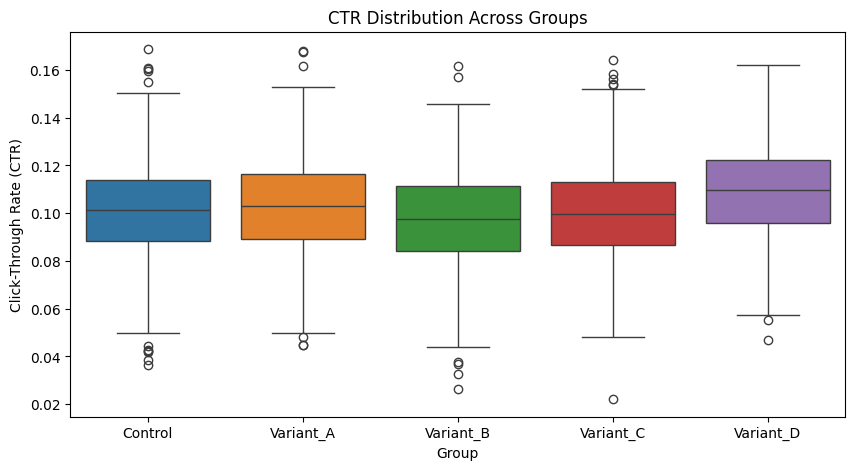

In [174]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Group', y='CTR', data=df, hue = 'Group')
plt.title("CTR Distribution Across Groups")
plt.ylabel("Click-Through Rate (CTR)")
plt.show()

### Step 2: Pairwise T-Tests - Finding Which Variants Are Different

In [175]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

# Function to perform two-sided t-tests and calculate lift
def perform_t_tests(df, control_group='Control'):
    results = []
    control_data = df[df['Group'] == control_group]['CTR']

    for group in df['Group'].unique():
        if group == control_group:
            continue
        test_data = df[df['Group'] == group]['CTR']
        
        # Perform independent two-sided t-test
        t_stat, p_val = ttest_ind(control_data, test_data, equal_var=False, alternative='two-sided')
        
        control_mean = np.mean(control_data)
        test_mean = np.mean(test_data)
        lift = ((test_mean - control_mean) / control_mean) * 100
        diff = test_mean - control_mean
        se_diff = np.sqrt(np.var(control_data, ddof=1) / len(control_data) + 
                          np.var(test_data, ddof=1) / len(test_data))
        ci_lower, ci_upper = diff - 1.96 * se_diff, diff + 1.96 * se_diff

        results.append({
            'Variant': group, 
            'T-Statistic': t_stat, 
            'P-Value': p_val,
            'CTR Lift (%)': round(lift, 2),
            '95% CI Lower': round(ci_lower, 5),
            '95% CI Upper': round(ci_upper, 5)
        })
    return pd.DataFrame(results)

# Run t-tests
t_test_results = perform_t_tests(df)
t_test_results


,Variant,T-Statistic,P-Value,CTR Lift (%),95% CI Lower,95% CI Upper
0,Variant_A,-1.966881,4.933518e-02,1.73,0.00001,0.00349
1,Variant_B,4.464269,8.482113e-06,-3.93,-0.00571,-0.00222
2,Variant_C,0.914248,3.606968e-01,-0.80,-0.00255,0.00093
3,Variant_D,-9.630738,1.723367e-21,8.50,0.00683,0.01032


In [176]:
from statsmodels.stats.multitest import multipletests

# Bonferroni correction
t_test_results['Bonferroni Corrected P'] = multipletests(t_test_results['P-Value'], method='bonferroni')[1]

# False Discovery Rate (FDR) correction
t_test_results['FDR Corrected P'] = multipletests(t_test_results['P-Value'], method='fdr_bh')[1]

alpha = 0.05  

# Check significance for each variant
t_test_results['Significant (Bonferroni)'] = t_test_results['Bonferroni Corrected P'] < alpha
t_test_results['Significant (FDR)'] = t_test_results['FDR Corrected P'] < alpha


t_test_results.round(5)

,Variant,T-Statistic,P-Value,CTR Lift (%),95% CI Lower,95% CI Upper,Bonferroni Corrected P,FDR Corrected P,Significant (Bonferroni),Significant (FDR)
0,Variant_A,-1.96688,0.04934,1.73,0.00001,0.00349,0.19734,0.06578,False,False
1,Variant_B,4.46427,0.00001,-3.93,-0.00571,-0.00222,0.00003,0.00002,True,True
2,Variant_C,0.91425,0.36070,-0.80,-0.00255,0.00093,1.00000,0.36070,False,False
3,Variant_D,-9.63074,0.00000,8.50,0.00683,0.01032,0.00000,0.00000,True,True
